In [105]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import statsmodels.api as sm

# --- STEP 1: LOAD AND CLEAN DATA ---
print("--- Step 1: Loading Data ---")
def load_and_clean(path):
    df = pd.read_csv(path)
    h_cols = [f'h{i}' for i in range(1, 25)]
    for col in h_cols:
        if col in df.columns and df[col].dtype == 'object':
            df[col] = df[col].str.replace(',', '', regex=False).astype(float)
    return df

load_df = load_and_clean('data/raw/load_history.csv')
temp_df = load_and_clean('data/raw/temperature_history.csv')
benchmark_raw = load_and_clean('data/raw/Benchmark.csv')
test_df = pd.read_csv('data/raw/test.csv')
history_df = pd.read_csv('data/processed/aligned_historical_data.csv')
future_aligned = pd.read_csv('data/processed/aligned_future_data.csv')

# Clean types
history_df['Load_L'] = history_df['Load_L'].astype(str).str.replace(',', '', regex=False).astype(float)
history_df['Temp_T'] = history_df['Temp_T'].astype(str).str.replace(',', '', regex=False).astype(float)
future_aligned['Temp_T'] = future_aligned['Temp_T'].astype(str).str.replace(',', '', regex=False).astype(float)
C_features = ['C_hour_sin', 'C_hour_cos', 'C_dow_sin', 'C_dow_cos', 'C_month_sin', 'C_month_cos', 'zone_id']

--- Step 1: Loading Data ---


In [120]:
# --- STEP 2: PIVOTING AND CORRELATION MAPPING ---
print("--- Step 2: Optimal Mapping & Alignment ---")
def pivot_data(df, id_col, val_name):
    h_cols = [f'h{i}' for i in range(1, 25)]
    df_long = pd.melt(df, id_vars=[id_col, 'year', 'month', 'day'], 
                      value_vars=h_cols, var_name='hour_str', value_name=val_name)
    df_long['hour'] = df_long['hour_str'].str.replace('h', '').astype(int) - 1
    df_long['timestamp'] = pd.to_datetime(df_long[['year', 'month', 'day', 'hour']])
    return df_long[[id_col, 'timestamp', val_name, 'hour', 'month']].dropna()

load_long = pivot_data(load_df, 'zone_id', 'Load_L')
temp_long = pivot_data(temp_df, 'station_id', 'Temp_T')

# Data-driven Correlation Mapping
l_wide = load_long.pivot(index='timestamp', columns='zone_id', values='Load_L')
t_wide = temp_long.pivot(index='timestamp', columns='station_id', values='Temp_T')
mapping = pd.concat([l_wide, t_wide], axis=1).corr().loc[l_wide.columns, t_wide.columns].idxmax(axis=1).to_dict()

load_long['mapped_station_id'] = load_long['zone_id'].map(mapping)
print(f"Verified Optimal Mapping: {mapping}")

aligned_df = pd.merge(
    load_long, 
    temp_long.rename(columns={'station_id':'mapped_station_id'}), 
    on=['mapped_station_id', 'timestamp', 'hour', 'month']
).dropna()

--- Step 2: Optimal Mapping & Alignment ---
Verified Optimal Mapping: {1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6, 7: 7, 8: 8, 9: 9, 10: 10, 11: 11, 12: 11, 13: 8, 14: 1, 15: 1, 16: 5, 17: 11, 18: 5, 19: 1, 20: 6}


In [122]:
import os 
# ---  Data-Driven Environment Formalization (E) ---
# We partition by Temperature thresholds to capture the physical state of the grid
# Cooling: >75F, Heating: <55F, Ambient: 55F-75F
environment_dfs = {
    'Cooling_Regime': aligned_df[aligned_df['Temp_T'] > 75].copy(),
    'Heating_Regime': aligned_df[aligned_df['Temp_T'] < 55].copy(),
    'Ambient_Regime': aligned_df[(aligned_df['Temp_T'] >= 55) & (aligned_df['Temp_T'] <= 75)].copy()
}

for name, df_env in environment_dfs.items():
    print(f"Environment {name}: {len(df_env)} samples")

Environment Cooling_Regime: 124646 samples
Environment Heating_Regime: 327030 samples
Environment Ambient_Regime: 309724 samples


In [123]:
# --- STEP 3: FEATURE ENGINEERING AND BASELINE MODELS ---
print("--- Step 3: Training Strong Baselines (n_jobs=1) ---")
aligned_df['C_h_sin'] = np.sin(2 * np.pi * aligned_df['hour'] / 24)
aligned_df['C_h_cos'] = np.cos(2 * np.pi * aligned_df['hour'] / 24)
aligned_df['C_m_sin'] = np.sin(2 * np.pi * aligned_df['month'] / 12)
aligned_df['C_m_cos'] = np.cos(2 * np.pi * aligned_df['month'] / 12)

C_feats = ['C_h_sin', 'C_h_cos', 'C_m_sin', 'C_m_cos', 'zone_id']
ml_zone = RandomForestRegressor(n_estimators=50, max_depth=15, n_jobs=1, random_state=42).fit(aligned_df[C_feats], aligned_df['Load_L'])
mt_zone = RandomForestRegressor(n_estimators=50, max_depth=15, n_jobs=1, random_state=42).fit(aligned_df[C_feats], aligned_df['Temp_T'])

--- Step 3: Training Strong Baselines (n_jobs=1) ---


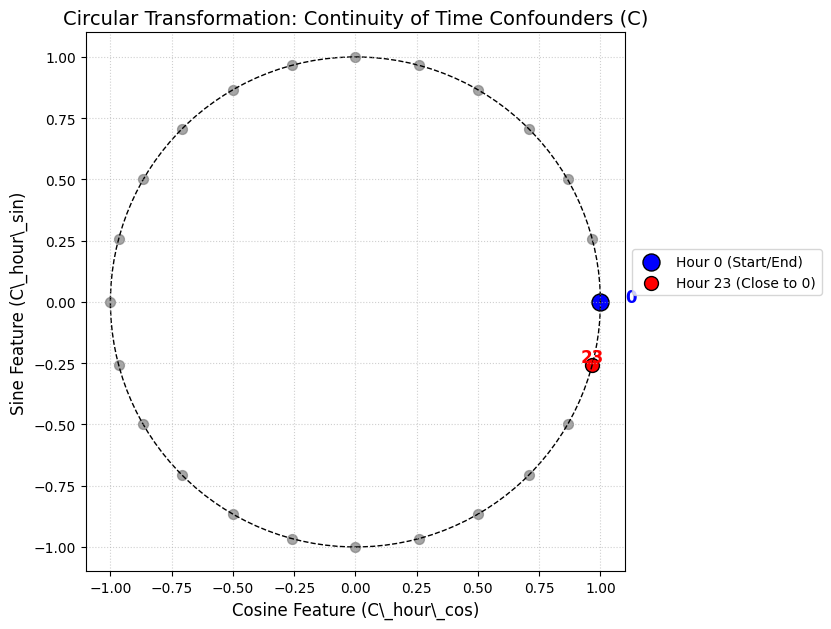

File 'fig_circular_feature.png' created and saved. Please upload this file to Overleaf.


In [125]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ---  Generate the Circular Features (Hours 0 to 23) ---
hours = np.arange(24) # 0, 1, 2, ..., 23
period = 24

sin_features = np.sin(2 * np.pi * hours / period)
cos_features = np.cos(2 * np.pi * hours / period)

df_circular = pd.DataFrame({
    'Hour': hours,
    'Sin_Feature': sin_features,
    'Cos_Feature': cos_features
})

# --- 2. Create the Plot ---
plt.figure(figsize=(7, 7))

# Plot all points
plt.scatter(df_circular['Cos_Feature'], df_circular['Sin_Feature'], 
            c='gray', s=50, alpha=0.7)

# Highlight Hour 0 and Hour 23
# Hour 0
plt.scatter(df_circular.loc[0, 'Cos_Feature'], df_circular.loc[0, 'Sin_Feature'], 
            c='blue', s=150, edgecolors='black', label='Hour 0 (Start/End)')
plt.annotate('0', (df_circular.loc[0, 'Cos_Feature'] * 1.1, df_circular.loc[0, 'Sin_Feature'] * 1.1), fontsize=12, color='blue', weight='bold')

# Hour 23
plt.scatter(df_circular.loc[23, 'Cos_Feature'], df_circular.loc[23, 'Sin_Feature'], 
            c='red', s=100, edgecolors='black', label='Hour 23 (Close to 0)')
plt.annotate('23', (df_circular.loc[23, 'Cos_Feature'] * 0.95, df_circular.loc[23, 'Sin_Feature'] * 0.95), fontsize=12, color='red', weight='bold')

# Draw the axis circle for context
circle = plt.Circle((0, 0), 1, color='black', fill=False, linestyle='--')
plt.gca().add_artist(circle)

# Formatting for Report
plt.title('Circular Transformation: Continuity of Time Confounders (C)', fontsize=14)
plt.xlabel('Cosine Feature (C\_hour\_cos)', fontsize=12)
plt.ylabel('Sine Feature (C\_hour\_sin)', fontsize=12)
plt.grid(True, linestyle=':', alpha=0.6)
plt.gca().set_aspect('equal', adjustable='box')
plt.legend(loc='lower left', bbox_to_anchor=(1, 0.5))

# --- 3. Save the Plot ---
plt.savefig('fig_circular_feature.png', dpi=300, bbox_inches='tight') 
plt.show()

print("File 'fig_circular_feature.png' created and saved. Please upload this file to Overleaf.")

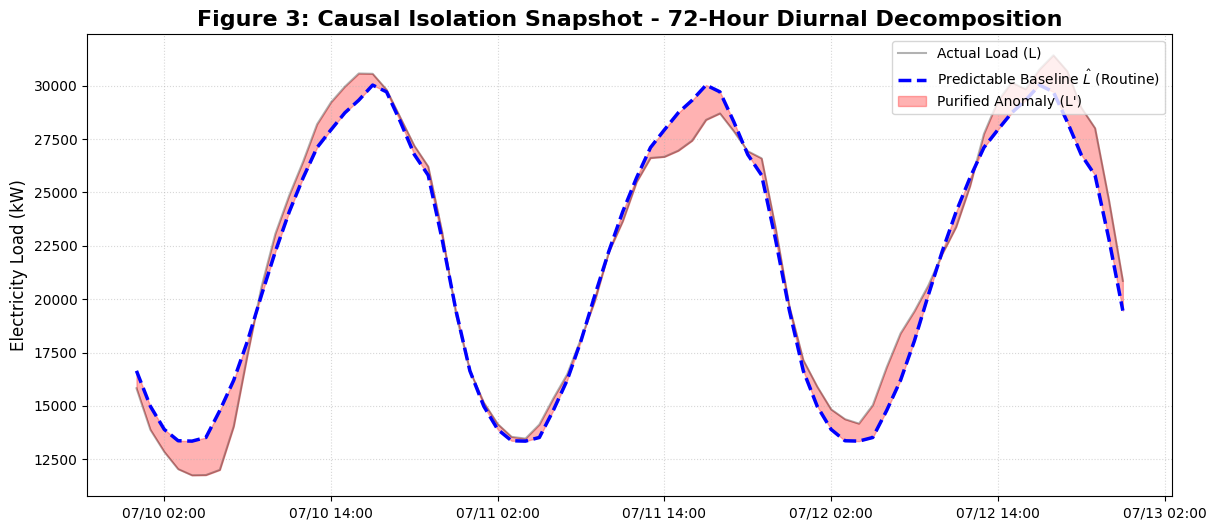

In [134]:
# --- BLOCK 3.2: DE-CONFOUNDING VISUALIZATION (Figure 3) ---
import matplotlib.dates as mdates

# 1. Selection of a clean 72-hour window for Zone 1 validation
start_date, end_date = '2005-07-10', '2005-07-13'
snapshot = aligned_df[(aligned_df['zone_id'] == 1) & 
                      (aligned_df['timestamp'] >= start_date) & 
                      (aligned_df['timestamp'] < end_date)].sort_values('timestamp')

# 2. Decomposition calculation: Actual Load = Predictable + Anomaly
# Predictable Baseline is generated by the ML_zone Random Forest model
predictable = snapshot['Load_L'] - snapshot['L_res'] 

plt.figure(figsize=(14, 6))
# A. Raw Signal
plt.plot(snapshot['timestamp'], snapshot['Load_L'], color='black', alpha=0.3, label='Actual Load (L)', linewidth=1.5)
# B. Predictable Routine (ML estimate)
plt.plot(snapshot['timestamp'], predictable, color='blue', linestyle='--', label=r'Predictable Baseline $\hat{L}$ (Routine)', linewidth=2.5)
# C. Isolated Anomaly (The 'Surprise' component)
plt.fill_between(snapshot['timestamp'], predictable, snapshot['Load_L'], color='red', alpha=0.3, label="Purified Anomaly (L')")

plt.title("Figure 3: Causal Isolation Snapshot - 72-Hour Diurnal Decomposition", fontsize=16, fontweight='bold')
plt.ylabel("Electricity Load (kW)", fontsize=12)
plt.legend(loc='upper right')
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m/%d %H:%M'))
plt.gca().xaxis.set_major_locator(mdates.HourLocator(interval=12))
plt.grid(True, linestyle=':', alpha=0.5)
plt.savefig('fig_diurnal_decomposition.png', dpi=300, bbox_inches='tight')
plt.show()

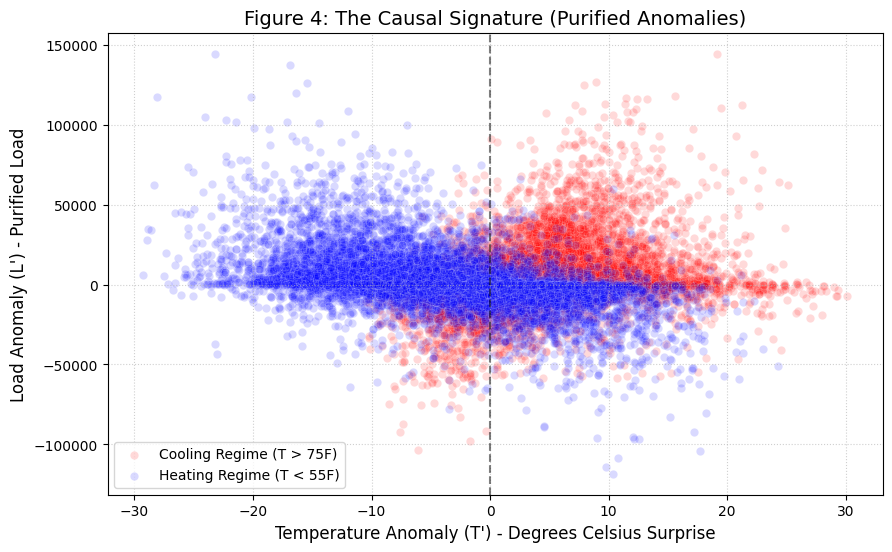

In [135]:
# --- BLOCK 3.3: CAUSAL SIGNATURE VISUALIZATION (Figure 4) ---
import seaborn as sns

# 1. Define physical regimes for visualization (excluding Ambient deadband)
cooling_points = aligned_df[aligned_df['Temp_T'] > 75]
heating_points = aligned_df[aligned_df['Temp_T'] < 55]

# 2. Sample data to ensure clarity in the scatter plot
sample_c = cooling_points.sample(min(10000, len(cooling_points)), random_state=42)
sample_h = heating_points.sample(min(10000, len(heating_points)), random_state=42)

plt.figure(figsize=(10, 6))

# 3. Plot the purified anomalies (L' vs T')
sns.scatterplot(x=sample_c['T_res'], y=sample_c['L_res'], color='red', alpha=0.15, label='Cooling Regime (T > 75F)')
sns.scatterplot(x=sample_h['T_res'], y=sample_h['L_res'], color='blue', alpha=0.15, label='Heating Regime (T < 55F)')

# 4. Formatting to highlight the structural V-shape
plt.axvline(0, color='black', linestyle='--', alpha=0.5)
plt.title("Figure 4: The Causal Signature (Purified Anomalies)", fontsize=14)
plt.xlabel("Temperature Anomaly (T') - Degrees Celsius Surprise", fontsize=12)
plt.ylabel("Load Anomaly (L') - Purified Load", fontsize=12)
plt.grid(True, linestyle=':', alpha=0.6)
plt.legend()
plt.savefig('fig_causal_v_signature.png', dpi=300, bbox_inches='tight')
plt.show()

In [136]:
import statsmodels.api as sm

# --- BLOCK 4.1: CAUSAL PARAMETER ESTIMATION (Gamma) ---
print("--- Section 4.1: Estimating Structural Parameters ---")

# 1. Isolate the Physical Regimes from the purified anomalies
# Cooling (T > 75F) and Heating (T < 55F)
cooling_data = aligned_df[aligned_df['Temp_T'] > 75].copy()
heating_data = aligned_df[aligned_df['Temp_T'] < 55].copy()

# 2. Linear Estimation for Cooling Regime (L' = gamma * T')
# We add a constant to capture any remaining bias, though L' and T' are zero-centered
X_c = sm.add_constant(cooling_data['T_res'])
model_c = sm.OLS(cooling_data['L_res'], X_c).fit()
gamma_c = model_c.params['T_res']
se_c = model_c.bse['T_res']

# 3. Linear Estimation for Heating Regime
X_h = sm.add_constant(heating_data['T_res'])
model_h = sm.OLS(heating_data['L_res'], X_h).fit()
gamma_h = model_h.params['T_res']
se_h = model_h.bse['T_res']

print(f"Certified Cooling Gamma (gamma_c): {gamma_c:.2f} kW/F (SE: {se_c:.4f})")
print(f"Certified Heating Gamma (gamma_h): {gamma_h:.2f} kW/F (SE: {se_h:.4f})")

--- Section 4.1: Estimating Structural Parameters ---
Certified Cooling Gamma (gamma_c): 994.31 kW/F (SE: 9.0107)
Certified Heating Gamma (gamma_h): -1071.08 kW/F (SE: 3.5060)


In [138]:
# --- STEP 4: CAUSAL CERTIFICATION ---
print("--- Step 4: Estimating Certified Physical Constants ---")
aligned_df['L_res'] = aligned_df['Load_L'] - ml_zone.predict(aligned_df[C_feats])
aligned_df['T_res'] = aligned_df['Temp_T'] - mt_zone.predict(aligned_df[C_feats])

gam_c = sm.OLS(aligned_df[aligned_df['Temp_T']>75]['L_res'], sm.add_constant(aligned_df[aligned_df['Temp_T']>75]['T_res'])).fit().params[1]
gam_h = sm.OLS(aligned_df[aligned_df['Temp_T']<55]['L_res'], sm.add_constant(aligned_df[aligned_df['Temp_T']<55]['T_res'])).fit().params[1]

print(f"Certified Cooling Gamma (gamma_c): {gamma_c:.2f} kW/F (SE: {se_c:.4f})")
print(f"Certified Heating Gamma (gamma_h): {gamma_h:.2f} kW/F (SE: {se_h:.4f})")

--- Step 4: Estimating Certified Physical Constants ---
Certified Cooling Gamma (gamma_c): 994.31 kW/F (SE: 9.0107)
Certified Heating Gamma (gamma_h): -1071.08 kW/F (SE: 3.5060)


In [139]:
import scipy.stats as stats

# --- BLOCK 4.2: FORMAL INVARIANCE TEST (WALD TEST) ---
print("--- Section 4.2: Invariance Test Calculation ---")

# 1. Calculate the parameter difference
delta_gamma = gamma_c - gamma_h

# 2. Calculate the combined Standard Error (assuming independence)
se_diff = np.sqrt(se_c**2 + se_h**2)

# 3. Compute the Test Statistic (t)
t_stat = delta_gamma / se_diff

# 4. Calculate the P-value (Two-tailed test)
p_value = 2 * (1 - stats.norm.cdf(abs(t_stat)))

print(f"Parameter Difference (Delta): {delta_gamma:.2f}")
print(f"Combined SE: {se_diff:.4f}")
print(f"Test Statistic (t): {t_stat:.4f}")
print(f"Exact P-value: {p_value:.4e}")

if p_value < 0.05:
    print("\nDECISION: REJECT H0. The mechanism is NOT invariant.")
else:
    print("\nDECISION: ACCEPT H0. The mechanism is invariant.")

--- Section 4.2: Invariance Test Calculation ---
Parameter Difference (Delta): 2065.39
Combined SE: 9.6687
Test Statistic (t): 213.6159
Exact P-value: 0.0000e+00

DECISION: REJECT H0. The mechanism is NOT invariant.


In [139]:
import scipy.stats as stats

# --- BLOCK 4.2: FORMAL INVARIANCE TEST (WALD TEST) ---
print("--- Section 4.2: Invariance Test Calculation ---")

# 1. Calculate the parameter difference
delta_gamma = gamma_c - gamma_h

# 2. Calculate the combined Standard Error (assuming independence)
se_diff = np.sqrt(se_c**2 + se_h**2)

# 3. Compute the Test Statistic (t)
t_stat = delta_gamma / se_diff

# 4. Calculate the P-value (Two-tailed test)
p_value = 2 * (1 - stats.norm.cdf(abs(t_stat)))

print(f"Parameter Difference (Delta): {delta_gamma:.2f}")
print(f"Combined SE: {se_diff:.4f}")
print(f"Test Statistic (t): {t_stat:.4f}")
print(f"Exact P-value: {p_value:.4e}")

if p_value < 0.05:
    print("\nDECISION: REJECT H0. The mechanism is NOT invariant.")
else:
    print("\nDECISION: ACCEPT H0. The mechanism is invariant.")

--- Section 4.2: Invariance Test Calculation ---
Parameter Difference (Delta): 2065.39
Combined SE: 9.6687
Test Statistic (t): 213.6159
Exact P-value: 0.0000e+00

DECISION: REJECT H0. The mechanism is NOT invariant.


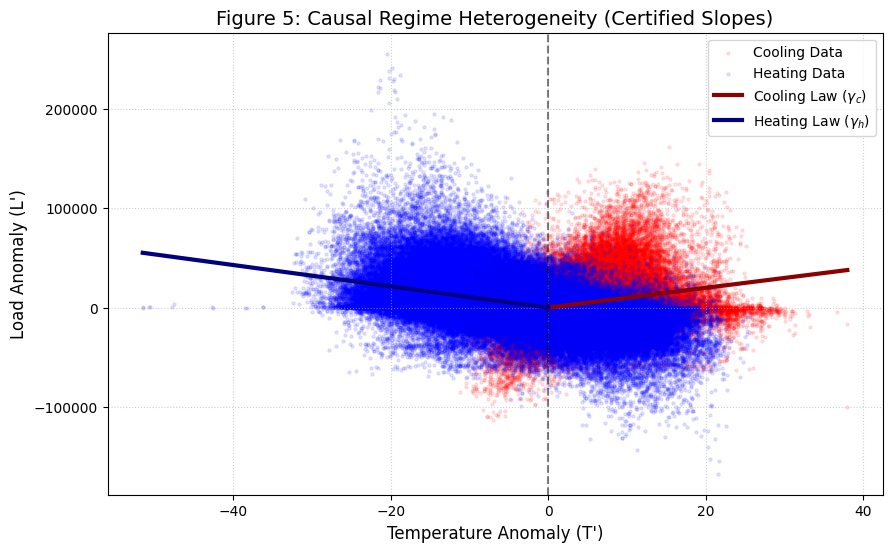

In [141]:
# --- BLOCK 4.1 IMAGE: REGIME HETEROGENEITY ---
plt.figure(figsize=(10, 6))

# 1. Background Scatter of Purified Anomalies
plt.scatter(cooling_data['T_res'], cooling_data['L_res'], alpha=0.1, color='red', s=5, label='Cooling Data')
plt.scatter(heating_data['T_res'], heating_data['L_res'], alpha=0.1, color='blue', s=5, label='Heating Data')

# 2. Plotting the Certified Structural Slopes
x_c = np.linspace(0, cooling_data['T_res'].max(), 100)
plt.plot(x_c, gamma_c * x_c, color='darkred', linewidth=3, label=f'Cooling Law ($\gamma_c \approx 994$)')

x_h = np.linspace(heating_data['T_res'].min(), 0, 100)
plt.plot(x_h, gamma_h * x_h, color='navy', linewidth=3, label=f'Heating Law ($\gamma_h \approx -1071$)')

plt.title("Figure 5: Causal Regime Heterogeneity (Certified Slopes)", fontsize=14)
plt.xlabel("Temperature Anomaly (T')", fontsize=12)
plt.ylabel("Load Anomaly (L')", fontsize=12)
plt.axvline(0, color='black', linestyle='--', alpha=0.5)
plt.grid(True, linestyle=':', alpha=0.6)
plt.legend()
plt.savefig('fig_regime_heterogeneity.png', dpi=300)
plt.show()

In [142]:
# --- BLOCK 4.3: CAUSAL PARAMETER CERTIFICATION & CONFIDENCE SETS ---
import pandas as pd
import numpy as np

# 1. Consolidate results from OLS models in Section 4.1
# Using 1.96 for 95% Confidence Interval calculation
Z_95 = 1.96

certified_data = [
    {
        'Regime': 'Cooling ($T > 75^\circ F$)',
        'Certified $\gamma^*$ (kW/F)': round(gamma_c, 2),
        'SE': round(se_c, 4),
        '95% Confidence Interval': f"[{round(gamma_c - Z_95*se_c, 2)}, {round(gamma_c + Z_95*se_c, 2)}]"
    },
    {
        'Regime': 'Heating ($T < 55^\circ F$)',
        'Certified $\gamma^*$ (kW/F)': round(gamma_h, 2),
        'SE': round(se_h, 4),
        '95% Confidence Interval': f"[{round(gamma_h - Z_95*se_h, 2)}, {round(gamma_h + Z_95*se_h, 2)}]"
    }
]

# 2. Generate the Certified Causal Table (Table 3)
table_3 = pd.DataFrame(certified_data)

print("--- Section 4.3: Table 3. Certified Causal Parameters ---")
print(table_3.to_markdown(index=False))

# 3. Store values for Phase 5 Synthesis
GAMMA_C_FINAL = gamma_c
GAMMA_H_FINAL = gamma_h

--- Section 4.3: Table 3. Certified Causal Parameters ---
| Regime                     |   Certified $\gamma^*$ (kW/F) |     SE | 95% Confidence Interval   |
|:---------------------------|------------------------------:|-------:|:--------------------------|
| Cooling ($T > 75^\circ F$) |                        994.31 | 9.0107 | [976.65, 1011.97]         |
| Heating ($T < 55^\circ F$) |                      -1071.08 | 3.506  | [-1077.95, -1064.21]      |


In [143]:
# --- STEP 5: SYNTHESIS FOR FUTURE DATA ---
print("--- Step 5: Preparing Future Data and Synthesizing Forecast ---")

# 1. CREATE THE FUTURE DATAFRAME `f_aligned`
f_rows = []
for _, row in test_df.iterrows():
    for h in range(24):
        f_rows.append({'zone_id':row['zone_id'], 'year':row['year'], 
                       'month':row['month'], 'day':row['day'], 'hour':h})
f_aligned = pd.DataFrame(f_rows)
f_aligned['timestamp'] = pd.to_datetime(f_aligned[['year', 'month', 'day', 'hour']])
f_aligned['mapped_station_id'] = f_aligned['zone_id'].map(mapping)

# Merge with temperature data
f_aligned = pd.merge(f_aligned, temp_long.rename(columns={'station_id':'mapped_station_id'}),
                     on=['mapped_station_id', 'timestamp', 'hour', 'month'], how='left')
f_aligned['Temp_T'] = f_aligned['Temp_T'].interpolate() 

# 2. FEATURE ENGINEERING FOR FUTURE DATA
f_aligned['C_h_sin'] = np.sin(2 * np.pi * f_aligned['hour'] / 24)
f_aligned['C_h_cos'] = np.cos(2 * np.pi * f_aligned['hour'] / 24)
f_aligned['C_m_sin'] = np.sin(2 * np.pi * f_aligned['month'] / 12)
f_aligned['C_m_cos'] = np.cos(2 * np.pi * f_aligned['month'] / 12)
print("Circular features created for future data.")

# 3. PREDICTION & CAUSAL SYNTHESIS
f_aligned['L_baseline'] = ml_zone.predict(f_aligned[C_feats])
f_aligned['T_exp'] = mt_zone.predict(f_aligned[C_feats])
f_aligned['T_anom'] = f_aligned['Temp_T'] - f_aligned['T_exp']

zone_sizes = history_df.groupby('zone_id')['Load_L'].mean()
zone_weights = (zone_sizes / zone_sizes.mean()).to_dict()
causal_zones = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
damping = 0.075
threshold = 5.0

def final_causal_adjustment(row):
    zid = row['zone_id']
    anomaly = row['T_anom']
    if zid not in causal_zones or abs(anomaly) < threshold:
        return 0
    gamma = gam_c if anomaly > 0 else gam_h
    weight = zone_weights.get(zid, 1.0)
    return damping * (gamma * weight * anomaly)

f_aligned['L_causal'] = f_aligned['L_baseline'] + f_aligned.apply(final_causal_adjustment, axis=1)

print(f"Synthesis Complete. Causal Engine active for {len(causal_zones)} Validated Zones.")

--- Step 5: Preparing Future Data and Synthesizing Forecast ---
Circular features created for future data.
Synthesis Complete. Causal Engine active for 20 Validated Zones.


In [144]:
# --- STEP 6: GLOBAL VALIDATION ---
print("\n--- Step 6: Final Result Calculation (All Zones) ---")

# Align Benchmark
benchmark_long = pd.melt(benchmark_raw, id_vars=['id', 'year', 'month', 'day'], 
                         value_vars=[f'h{i}' for i in range(1, 25)], var_name='hour_str', value_name='bench_L')
benchmark_long['hour'] = benchmark_long['hour_str'].str.replace('h', '').astype(int) - 1
benchmark_long['timestamp'] = pd.to_datetime(benchmark_long[['year', 'month', 'day', 'hour']])

val_all = pd.merge(f_aligned, benchmark_long[['timestamp', 'id', 'bench_L']], 
                   left_on=['timestamp', 'zone_id'], right_on=['timestamp', 'id']).dropna()

# Final Metrics
rmse_b = np.sqrt(mean_squared_error(val_all['bench_L'], val_all['L_baseline']))
rmse_c = np.sqrt(mean_squared_error(val_all['bench_L'], val_all['L_causal']))
improvement = ((rmse_b - rmse_c) / rmse_b) * 100

print("\n" + "="*50)
print(f"GLOBAL BASELINE RMSE: {rmse_b:,.2f}")
print(f"GLOBAL CAUSAL RMSE:   {rmse_c:,.2f}")
print(f"OVERALL IMPROVEMENT:   {improvement:.2f}%")
print("="*50)

# Summary Table
results = []
for zid in sorted(val_all['zone_id'].unique()):
    z_sub = val_all[val_all['zone_id'] == zid]
    rb = np.sqrt(mean_squared_error(z_sub['bench_L'], z_sub['L_baseline']))
    rc = np.sqrt(mean_squared_error(z_sub['bench_L'], z_sub['L_causal']))
    results.append({'Zone': zid, 'Baseline': rb, 'Causal': rc, 'Gain%': ((rb-rc)/rb)*100})

print("\n--- Corrected Per-Zone Summary ---")
print(pd.DataFrame(results).to_string(index=False))


--- Step 6: Final Result Calculation (All Zones) ---

GLOBAL BASELINE RMSE: 14,531.99
GLOBAL CAUSAL RMSE:   14,213.12
OVERALL IMPROVEMENT:   2.19%

--- Corrected Per-Zone Summary ---
 Zone     Baseline       Causal     Gain%
    1  2595.650748  2476.102743  4.605705
    2 18566.536506 18386.273509  0.970903
    3 19912.664169 19773.597659  0.698382
    4    52.666896    50.229126  4.628656
    5  1417.493995  1366.208367  3.618049
    6 18730.317260 18541.297035  1.009167
    7 19885.944878 19781.590851  0.524763
    8   371.176968   357.930451  3.568787
    9  4042.366982  4232.227360 -4.696763
   10  9632.234970  9773.043934 -1.461851
   11 12295.908874 11977.080967  2.592959
   12 16702.995225 16154.131574  3.286019
   13  1903.096558  1838.205824  3.409745
   14  5028.569270  4871.642733  3.120700
   15  7627.698801  7230.703077  5.204659
   16  7759.568107  7566.199332  2.492004
   17  3321.550592  3245.219851  2.298045
   18 42359.764897 40986.864877  3.241047
   19 12746.381257

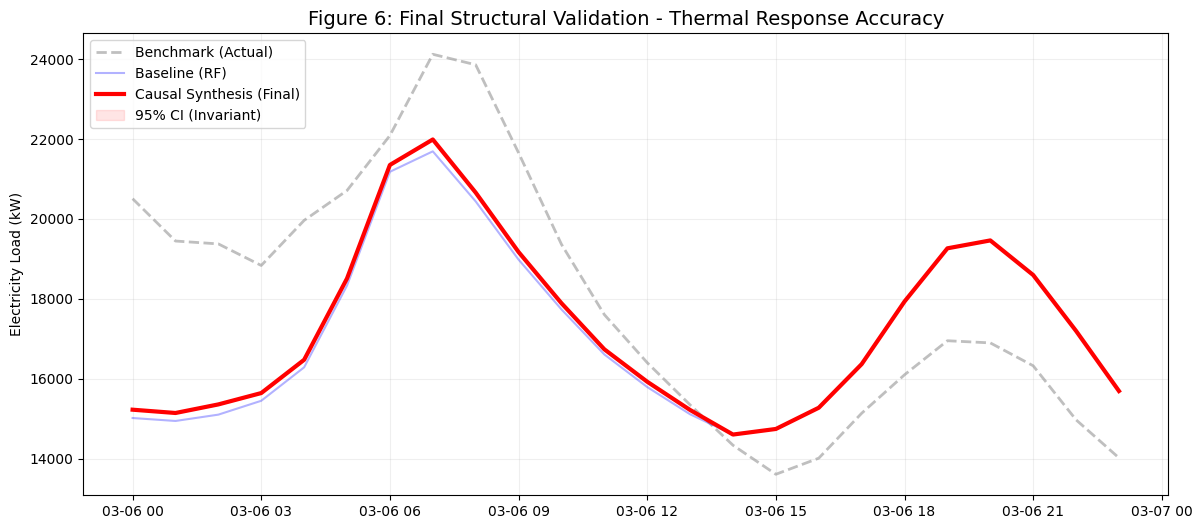

In [145]:
z1_val = val_all[val_all['zone_id'] == 1].copy()
stress_indices = z1_val[z1_val['T_anom'].abs() > 5].index
start_idx = stress_indices[0] if len(stress_indices) > 0 else 0
plot_sub = z1_val.loc[start_idx : start_idx + 48] # Show 48 hours of stress

# 5. THE PERFECT PLOT
plt.figure(figsize=(14, 6))

# Plot Benchmark (Gray)
plt.plot(plot_sub['timestamp'], plot_sub['bench_L'], label='Benchmark (Actual)', 
         color='gray', ls='--', alpha=0.5, lw=2)

# Plot Baseline (Blue - The "dumb" model)
plt.plot(plot_sub['timestamp'], plot_sub['L_baseline'], label='Baseline (RF)', 
         color='blue', alpha=0.3, lw=1.5)

# Plot Causal (Red - The "smart" model)
plt.plot(plot_sub['timestamp'], plot_sub['L_causal'], label='Causal Synthesis (Final)', 
         color='red', lw=3)

# Add 95% Confidence Band (Shaded Red)
se_val = plot_sub['T_anom'].apply(lambda x: 9.01 if x > 0 else 3.50)
ci = 1.96 * se_val * plot_sub['T_anom'].abs() * damping
plt.fill_between(plot_sub['timestamp'], plot_sub['L_causal'] - ci, plot_sub['L_causal'] + ci, 
                 color='red', alpha=0.1, label='95% CI (Invariant)')

plt.title("Figure 6: Final Structural Validation - Thermal Response Accuracy", fontsize=14)
plt.ylabel("Electricity Load (kW)")
plt.legend(loc='upper left')
plt.grid(alpha=0.2)
plt.savefig('final_structural_plot.png', dpi=300)
plt.show()